# Load data

In [17]:
classes = ["epithelial","fibroblast","inflammatory","others"]

In [3]:
import cv2
import matplotlib.image as mplib 
from PIL import Image
import numpy as np

def load_data(labelNames, root):    
    images = list()
    labels = list()
    
    for label in labelNames:
        # get image directory
        img_dir = os.path.join(root, f"{label}")
        
        for img in os.listdir(img_dir):
            img = np.array(Image.open(os.path.join(img_dir, img),'r'))
            images.append(img)
            labels.append(label)
        
    return (images, labels)

In [4]:
multiclass_path = "Image_classification_data/multi-task"
images, labels = load_data(classes, multiclass_path)
images = np.asarray(images)
labels = np.asarray(labels)
print(images.shape)
print(labels.shape)

(9896, 27, 27, 3)
(9896,)


# Preprocess data

## Construct Features: Color Histogram

In [5]:
class ColorDescriptor:

    def __init__(self, bins):
		# store the number of bins for the 3D histogram
        self.bins = bins
    
    def histogram(self,image, mask):
        	# extract a 3D color histogram from the masked region of the
		# image, using the supplied number of bins per channel
        hist = cv2.calcHist([image], [0, 1, 2], mask, self.bins, [0, 256, 0, 256, 0, 256])
		# normalize the histogram 
        hist = cv2.normalize(hist, hist).flatten() # help the difference in image dimension
		# return the histogram
        return hist
    def describe(self, image):
		# convert the image to the HSV color space and initialize
		# the features used to quantify the image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        features = []
		# grab the dimensions and compute the center of the image
        (h, w) = image.shape[:2]
        (cX, cY) = (int(w * 0.5), int(h * 0.5))

        # Divide image into 5 regions (top-left,
        # top-right, bottom-right, bottom-left, center oval)
        segments = [(0, cX, 0, cY), (cX, w, 0, cY), (cX, w, cY, h),
            (0, cX, cY, h)]
        # construct an elliptical mask representing the center of the
        # image
        (axesX, axesY) = (int(w * 0.75) // 2, int(h * 0.75) // 2)
        ellipMask = np.zeros(image.shape[:2], dtype = "uint8") # center
        cv2.ellipse(ellipMask, (cX, cY), (axesX, axesY), 0, 0, 360, 255, -1)
        
        # loop over the segments
        for (startX, endX, startY, endY) in segments:
            # construct a mask for each corner of the image, subtracting
            # the elliptical center from it
            cornerMask = np.zeros(image.shape[:2], dtype = "uint8")
            cv2.rectangle(cornerMask, (startX, startY), (endX, endY), 255, -1)
            cornerMask = cv2.subtract(cornerMask, ellipMask)
            # extract a color histogram from the image, then update the
            # feature vector
            hist = self.histogram(image, cornerMask)
            features.extend(hist)
        # extract a color histogram from the elliptical region and
        # update the feature vector
        hist = self.histogram(image, ellipMask)
        features.extend(hist)
        # return the feature vector
        return features



In [9]:
descriptor = ColorDescriptor([8,8,8])
images = [descriptor.describe(im) for im in images]

In [10]:
np.asarray(images).shape

(9896, 2560)

## Split dataset: training, and testing

In [21]:
from sklearn.model_selection import train_test_split
trainX, valX, trainY, valY = train_test_split(images, labels, test_size=0.2, random_state=4)
np.asarray(trainX).shape

(7916, 2560)

## PCA

In [29]:
from sklearn.decomposition import PCA

pca = PCA(50)
pca.fit(trainX)
## Training
transformed_trainX = pca.transform(trainX)
print(np.sum(pca.explained_variance_ratio_) )

## Testing
transformed_valX = pca.transform(valX)

0.9294395534607484


# Model KNN

In [30]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(
	n_neighbors=len(classes),
	n_jobs=-1, 
	metric="manhattan")

knn.fit(transformed_trainX, trainY)

acc = knn.score(transformed_valX, valY)

print("[INFO] Validation accuracy: {:.2f}%".format(acc * 100))

[INFO] Validation accuracy: 66.36%


# Model Random Forest

In [31]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(transformed_trainX, trainY)
rfc.score(transformed_valX, valY)

0.7181818181818181

# Light XGM Boosting

In [32]:
from sklearn.ensemble import HistGradientBoostingClassifier

histgb = HistGradientBoostingClassifier()
histgb.fit(transformed_trainX, trainY)
histgb.score(transformed_valX, valY)

0.7262626262626263

# Ensemble Learner

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

lr = DecisionTreeClassifier()
submodels = [("rfc", rfc), ("histgb", histgb), ("knn",knn)]
stacker = StackingClassifier(estimators=submodels, final_estimator=lr, stack_method="predict", n_jobs=-1)

stacker.fit(transformed_trainX, trainY)
stacker_score  = stacker.score(transformed_valX, valY)
stacker_score

0.7257575757575757

In [42]:
from sklearn.metrics import classification_report
pred_stack = stacker.predict(transformed_valX)

print(classification_report(valY, pred_stack))

              precision    recall  f1-score   support

  epithelial       0.85      0.91      0.88       798
  fibroblast       0.60      0.65      0.62       371
inflammatory       0.66      0.66      0.66       513
      others       0.62      0.44      0.51       298

    accuracy                           0.73      1980
   macro avg       0.68      0.66      0.67      1980
weighted avg       0.72      0.73      0.72      1980



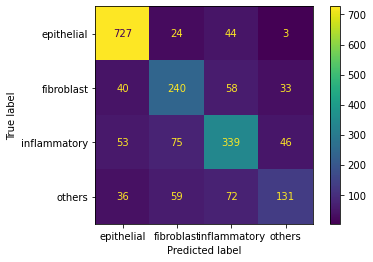

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(valY, pred_stack)
dist = ConfusionMatrixDisplay(cm, display_labels=classes)
dist.plot()
plt.show()